In [1]:
from data_config import DATA_FOLDER
import json
from PIL import Image
import numpy as np

import torch
from transformers import ViltConfig

vilt_config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Inspect the Data

In [2]:
VQA_questions = DATA_FOLDER + "marvl-images/data/vqa_vlue_test.json"

# Opening JSON file
f = open(VQA_questions)

# Return JSON object as dictionary
data_questions = json.load(f)
print(f"Length of data_questions: {len(data_questions)}")
print(data_questions[0].keys())

Length of data_questions: 11942
dict_keys(['question_id', 'question', 'image', 'answer'])


In [3]:
# Print the question and answer
print(f"The question is: {data_questions[0]['question']}")
print(f"The answer is: {data_questions[0]['answer']}")

# Print the IDs for the answer
ans = vilt_config.label2id[data_questions[0]["answer"]]
print(f"IDs for the answer: {ans}")

The question is: Is there only one piece of paper here?
The answer is: yes
IDs for the answer: 3


dict_keys(['question_id', 'question', 'image', 'answer'])

The question is:
 Is there only one piece of paper here?
The answer is: yes
IDs for the answer: 3


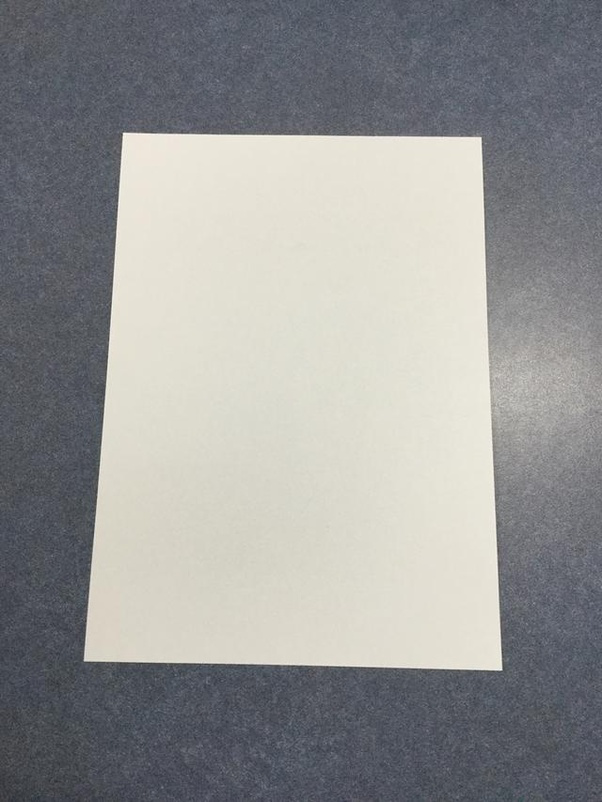

In [4]:
import random
from IPython.display import display
# Set an example
example = data_questions[0] # data_questions[random.randint(0, len(data_questions))]
print(example.keys())

# Print the question
print(f"\nThe question is:\n {example['question']}")

# Print the labels i.e., answers
print(f"The answer is: {example['answer']}")

# Print the IDs for the answer
ans = vilt_config.label2id[example["answer"]]
print(f"IDs for the answer: {ans}")

# Print the image
image = Image.open(DATA_FOLDER + "marvl-images/" + example["image"])
# display(image)
image_array = np.array(image)

# # Perform the operations (assuming image_mean and image_std are defined)
# # Uncomment and adjust the following lines as needed
# unnormalized_image = (image_array * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
# unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(image_array)

# Convert the NumPy array back to an image
# unnormalized_image = Image.fromarray(unnormalized_image)


# image.show()
# unnormalized_image = (example["pixel_values"][batch_idx].numpy() * np.array(image_mean)[:, None, None]) + np.array(image_std)[:, None, None]
# unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
# Image.fromarray(image)

# Prepare the dataset

In [5]:
import torch
from PIL import Image
from transformers import ViltProcessor

class CustomVQADataset(torch.utils.data.Dataset):
    """Custom VQA dataset."""

    # def __init__(self, data, processor, id2label, label2id):
    def __init__(self, data, processor, config):
        self.data = data
        self.processor = processor
        self.config = config
        # self.id2label = id2label
        # self.label2id = label2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        datapoint = self.data[idx]
        image = Image.open(DATA_FOLDER + "marvl-images/" + datapoint['image'])
        text = datapoint['question']
        answer = datapoint['answer']

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()
        
        # add labels
        targets = torch.zeros(len(self.config.id2label))
        if answer in self.config.label2id:
            label = self.config.label2id[answer]
            targets[label] = 1.0
        encoding["labels"] = targets

        return encoding


processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa", cache_dir="/data-4/users/mileriso/models")

# Assuming config is defined and has id2label and label2id mappings
# Assuming data is a list of dictionaries with keys ['question_id', 'question', 'image', 'answer']
dataset = CustomVQADataset(data=data_questions[:100], processor=processor, config=vilt_config)

In [6]:
dataset[0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [7]:
processor.decode(dataset[0]['input_ids'])

'[CLS] is there only one piece of paper here? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [8]:
labels = [torch.nonzero(dataset[0]['labels']).squeeze().tolist()]


In [9]:
[vilt_config.id2label[label] for label in labels]

['yes']

# Initializa the model

### ViLT Model

In [22]:
# import torch
# from transformers import ViltForQuestionAnswering

# # Load the models
# model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa", cache_dir="/data-4/users/mileriso/models",
#                                                   id2label=vilt_config.id2label,
#                                                   label2id=vilt_config.label2id)
# model.to(device)
# model.eval()

### Meter Model

In [23]:
import os
import copy
import pytorch_lightning as pl
from meter.config import ex
from meter.modules import METERTransformerSS
from meter.datamodules.multitask_datamodule import MTDataModule

from sacred import Experiment

ex = Experiment("METER", interactive=True)

def _loss_names(d):
    ret = {
        "itm": 0,
        "mlm": 0,
        "mpp": 0,
        "vqa": 0,
        "vcr": 0,
        "vcr_qar": 0,
        "nlvr2": 0,
        "irtr": 0,
        "contras": 0,
        "snli": 0,
    }
    ret.update(d)
    return ret


@ex.config
def config():
    exp_name = "meter"
    seed = 0
    datasets = ["coco", "vg", "sbu", "gcc"]
    loss_names = _loss_names({"itm": 1, "mlm": 1})
    batch_size = 4096  # this is a desired batch size; pl trainer will accumulate gradients when per step batch is smaller.

    # Image setting
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    image_size = 224
    patch_size = 32
    draw_false_image = 1
    image_only = False
    resolution_before = 224

    # Text Setting
    vqav2_label_size = 3129
    max_text_len = 40
    tokenizer = "bert-base-uncased"
    vocab_size = 30522
    whole_word_masking = False # note that whole_word_masking does not work for RoBERTa
    mlm_prob = 0.15
    draw_false_text = 0

    # Transformer Setting
    num_top_layer = 6
    input_image_embed_size = 768
    input_text_embed_size = 768
    vit = 'ViT-B/32'
    hidden_size = 768
    num_heads = 12
    num_layers = 6
    mlp_ratio = 4
    drop_rate = 0.1

    # Optimizer Setting
    optim_type = "adamw"
    learning_rate = 1e-5
    weight_decay = 0.01
    decay_power = 1
    max_epoch = 100
    max_steps = 100000
    warmup_steps = 10000
    end_lr = 0
    lr_mult_head = 5  # multiply lr for downstream heads
    lr_mult_cross_modal = 5  # multiply lr for the cross-modal module

    # Downstream Setting
    get_recall_metric = False

    # PL Trainer Setting
    resume_from = None
    fast_dev_run = False
    val_check_interval = 1.0
    test_only = False

    # below params varies with the environment
    data_root = ""
    log_dir = "result"
    per_gpu_batchsize = 0  # you should define this manually with per_gpu_batch_size=#
    num_gpus = 8
    num_nodes = 1
    load_path = ""
    num_workers = 8
    precision = 32


@ex.named_config
def task_mlm_itm_clip_bert():
    exp_name = "mlm_itm"
    datasets = ["coco", "vg", "sbu", "gcc"]
    loss_names = _loss_names({"itm": 1, "mlm": 1})
    batch_size = 4096
    max_epoch = 10
    max_steps = 100000
    warmup_steps = 0.1
    whole_word_masking = True

    vocab_size = 30522
    max_text_len = 50
    image_size = 224
    tokenizer = "bert-base-uncased"
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    learning_rate = 1e-5
    val_check_interval = 1.0
    lr_mult_head = 5
    lr_mult_cross_modal = 5
    num_top_layer = 6
    hidden_size = 768
    num_heads = 12

@ex.named_config
def task_finetune_nlvr2_clip_bert():
    exp_name = "finetune_nlvr2"
    datasets = ["nlvr2"]
    loss_names = _loss_names({"nlvr2": 1})
    batch_size = 256
    max_epoch = 10
    max_steps = None
    warmup_steps = 0.1
    draw_false_image = 0
    learning_rate = 1e-5
    lr_mult_head = 10
    lr_mult_cross_modal = 5
    tokenizer = "bert-base-uncased"
    max_text_len = 50
    input_text_embed_size = 768
    vit = 'ViT-B/32'
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    input_image_embed_size = 768
    image_size = 288

@ex.named_config
def task_finetune_vqa_clip_bert():
    exp_name = "finetune_vqa"
    datasets = ["vqa"]
    loss_names = _loss_names({"vqa": 1})
    batch_size = 512
    max_epoch = 10
    max_steps = None
    warmup_steps = 0.1
    draw_false_image = 0
    learning_rate = 5e-6
    val_check_interval = 0.1
    lr_mult_head = 50
    lr_mult_cross_modal = 5
    tokenizer = "bert-base-uncased"
    max_text_len = 50
    input_text_embed_size = 768
    vit = 'ViT-B/32'
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    input_image_embed_size = 768
    image_size = 576

@ex.named_config
def task_finetune_irtr_coco_clip_bert():
    exp_name = "finetune_irtr_coco"
    datasets = ["coco"]
    loss_names = _loss_names({"itm": 0.5, "irtr": 1})
    batch_size = 512
    max_epoch = 10
    max_steps = None
    warmup_steps = 0.1
    get_recall_metric = True
    draw_false_text = 15
    learning_rate = 5e-6
    lr_mult_head = 5
    lr_mult_cross_modal = 5
    tokenizer = "bert-base-uncased"
    input_text_embed_size = 768
    vit = 'ViT-B/32'
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    input_image_embed_size = 768
    image_size = 384

@ex.named_config
def task_finetune_irtr_f30k_clip_bert():
    exp_name = "finetune_irtr_f30k"
    datasets = ["f30k"]
    loss_names = _loss_names({"itm": 0.5, "irtr": 1})
    batch_size = 512
    max_epoch = 10
    max_steps = None
    warmup_steps = 0.1
    get_recall_metric = True
    draw_false_text = 15
    learning_rate = 5e-6
    lr_mult_head = 5
    lr_mult_cross_modal = 5
    tokenizer = "bert-base-uncased"
    input_text_embed_size = 768
    vit = 'ViT-B/32'
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    input_image_embed_size = 768
    image_size = 384

@ex.named_config
def task_finetune_snli_clip_bert():
    exp_name = "finetune_snli"
    datasets = ["snli"]
    loss_names = _loss_names({"snli": 1})
    batch_size = 64
    max_epoch = 5
    max_steps = None
    warmup_steps = 0.1
    draw_false_image = 0
    learning_rate = 2e-6
    lr_mult_head = 10
    lr_mult_cross_modal = 5
    tokenizer = "bert-base-uncased"
    max_text_len = 50
    input_text_embed_size = 768
    vit = 'ViT-B/32'
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    input_image_embed_size = 768
    image_size = 384


# Named configs for "etc" which are orthogonal to "env" and "task", need to be added at the end

# vision encoder
@ex.named_config
def swin32_base224():
    vit = "swin_base_patch4_window7_224_in22k"
    patch_size = 32
    image_size = 224
    train_transform_keys = ["imagenet"]
    val_transform_keys = ["imagenet"]
    input_image_embed_size = 1024
    resolution_before = 224

@ex.named_config
def swin32_base384():
    vit = "swin_base_patch4_window12_384_in22k"
    patch_size = 32
    image_size = 384
    train_transform_keys = ["imagenet"]
    val_transform_keys = ["imagenet"]
    input_image_embed_size = 1024
    resolution_before = 384

@ex.named_config
def swin32_large384():
    vit = "swin_large_patch4_window12_384_in22k"
    patch_size = 32
    image_size = 384
    train_transform_keys = ["imagenet"]
    val_transform_keys = ["imagenet"]
    input_image_embed_size = 1536
    resolution_before = 384

@ex.named_config
def clip32():
    vit = 'ViT-B/32'
    image_size = 224
    patch_size = 32
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    input_image_embed_size = 768

@ex.named_config
def clip16():
    vit = 'ViT-B/16'
    image_size = 224
    patch_size = 16
    train_transform_keys = ["clip"]
    val_transform_keys = ["clip"]
    input_image_embed_size = 768

# text encoder
@ex.named_config
def text_roberta():
    tokenizer = "roberta-base"
    vocab_size = 50265
    input_text_embed_size = 768

@ex.named_config
def text_roberta_large():
    tokenizer = "roberta-large"
    vocab_size = 50265
    input_text_embed_size = 1024

# random augmentation
@ex.named_config
def imagenet_randaug():
    train_transform_keys = ["imagenet_randaug"]

@ex.named_config
def clip_randaug():
    train_transform_keys = ["clip_randaug"]

def set_configurations():
    
    # Initialize the default configuration
    cfg = config()
    # config(cfg)
    
    # Update the configuration with the specified values
    cfg.update({
        "data_root": "/data-4/users/mileriso/datasets/Flickr30k/arrows/",
        "num_gpus": 2,
        "num_nodes": 1,
        "get_recall_metric": True,
        "per_gpu_batchsize": 32,
        "load_path": "/data-4/users/mileriso/models/meter_vqa.ckpt",
        "image_size": 224,
        "test_only": True,
        "vit": "ViT-B/16",
        
        "tokenizer": "bert-base-uncased",
        # "tokenizer": "text_roberta",
        
        "vocab_size": 50265,
        "hidden_size": 768,
        "num_layers": 6,
        "num_heads": 12,
        "mlp_ratio": 4,
        "lr_mult_head": 50,
        "max_text_len": 514,
        "vit": 'ViT-B/16',
        "image_size": 224,
        "patch_size": 16,
        "train_transform_keys": "clip",
        "val_transform_keys": "clip",
        "input_image_embed_size": 768,
    })
    
    # Apply named configurations
    # task_finetune_vqa_clip_bert(cfg)
    # clip16(cfg)
    # text_roberta(cfg)
    
    return cfg

# Set the configurations
_config = set_configurations()

In [24]:
# Initialize the METERTransformerSS class with the specified configurations
model = METERTransformerSS(_config).to(device)

# Print the model to verify initialization
# print(model)

/home/mileriso/envs/.meter/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [25]:
def prepare_batch(encoding):
    """
    Prepare the input batch for the METER model

    Parameters:
    - encoding: dictionary containing the image, text, and labels used in ViLT model

    Returns:
    - batch: dictionary containing the input_ids, token_type_ids, attention_mask, pixel_values, pixel_mask, and labels
    """
    
    # Prepare the batch dictionary
    batch = {
        "image": encoding["pixel_values"],
        "text_ids": encoding["input_ids"],
        "text_labels": encoding["labels"],
        "text_masks": encoding["attention_mask"],
        "token_type_ids": encoding["token_type_ids"],
        "pixel_mask": encoding["pixel_mask"],
        
    }
    return batch

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])
Image shape: torch.Size([3, 384, 576])

The question is:
 [CLS] what colour is the cat ？ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

The labels are:
 ['yellow']


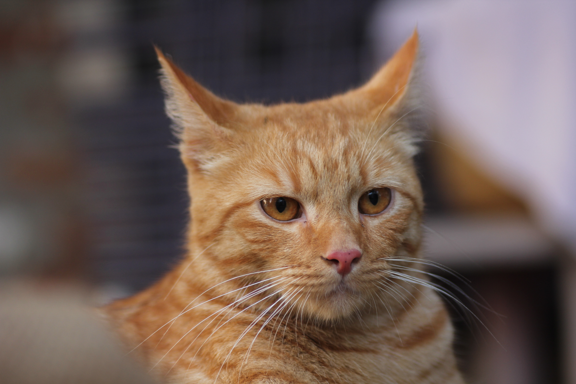

Shape of pixel_values: torch.Size([1, 1, 3, 224, 224])
Shape of example: torch.Size([1, 40])
Shape of example: torch.Size([1, 40])
Shape of example: torch.Size([1, 3129])
Shape of example: torch.Size([1, 1, 384, 576])
Infer Successful
dict_keys(['text_feats', 'image_feats', 'cls_feats', 'text_labels', 'text_ids', 'text_masks'])
Ouput text labels: tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
1.0 yellow
0.0 orange
0.0 net
0.0 yes
0.0 pitcher


In [62]:
import random
from IPython.display import display
import numpy as np
from PIL import Image

batch_idx = 0  # Ensure batch_idx is within the correct range

# Set an example
example = dataset[random.randint(0, len(dataset) - 1)]
print(example.keys())

print(f"Image shape: {example['pixel_values'].shape}")

# Print the question
print(f"\nThe question is:\n {processor.decode(example['input_ids'])}")

# Print the labels i.e., answers
labels = torch.nonzero(example['labels']).squeeze().tolist()
if isinstance(labels, int):
    labels = [labels]
print(f"\nThe labels are:\n {[vilt_config.id2label[label] for label in labels]}")

image_mean = processor.image_processor.image_mean
image_std = processor.image_processor.image_std

# Print the image
unnormalized_image = (example["pixel_values"].numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = Image.fromarray(unnormalized_image, 'RGB')
display(unnormalized_image)


###########################################
############ Perform inference ############
###########################################

from PIL import Image
import torch
from torchvision import transforms

# Convert tensor to PIL Image
def tensor_to_pil(tensor):
    return transforms.ToPILImage()(tensor)

# Define the transform to resize the images
resize_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size expected by the model
    transforms.ToTensor()
])

# Convert the tensor to PIL Image, apply the transform, and convert back to tensor
example['pixel_values'] = resize_transform(tensor_to_pil(example['pixel_values']))

# Add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k, v in example.items()}
example['pixel_values'] = example['pixel_values'].unsqueeze(0)
example['pixel_mask'] = example['pixel_mask'].unsqueeze(0)

print(f"Shape of pixel_values: {example['pixel_values'].shape}")
print(f"Shape of example: {example['input_ids'].shape}")
print(f"Shape of example: {example['attention_mask'].shape}")
print(f"Shape of example: {example['labels'].shape}")
print(f"Shape of example: {example['pixel_mask'].shape}")

# Forward pass
example = prepare_batch(example)
outputs = model(example)

print(outputs.keys())

# Process the outputs
# Assuming 'cls_feats' contains the logits
print(f"Ouput text labels: {outputs['text_labels']}")
logits = outputs['text_labels']
predicted_classes = torch.sigmoid(logits)

probs, classes = torch.topk(logits, 5)

for prob, class_idx in zip(probs.squeeze().tolist(), classes.squeeze().tolist()):
    print(prob, vilt_config.id2label[class_idx])